### Import Required Libraries:

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load the data

In [4]:
import pandas as pd
import numpy as np

# Load the data from CSV file
data = pd.read_csv('Val-12BPM.csv')

### Process the Data

In [5]:
# Extract the CSI_DATA column and clean it
# Skip the first three metadata values in each sample and convert strings to numeric lists
def process_csi_data(row):
    try:
        # Remove brackets, split by whitespace, and skip the first three elements (metadata)
        values = row.strip('[]').split()[12:]
        # Convert to floats, handling potential conversion errors
        return np.array([float(val) for val in values])
    except ValueError:
        # Return empty array if conversion fails
        return np.array([])

# Apply processing to each row in 'CSI_DATA'
csi_data = data['CSI_DATA'].apply(process_csi_data)

# Filter out empty arrays (in case of conversion errors)
csi_data = [sample for sample in csi_data if sample.size > 0]


### Calculate the amplitudes

In [6]:
# Calculate the amplitude for each sample
amplitudes = []
for sample in csi_data:
    # Separate real and imaginary parts assuming alternating pattern
    real_parts = sample[::2]
    imag_parts = sample[1::2]

    # Calculate magnitude (amplitude)
    amplitude_sample = np.sqrt(real_parts**2 + imag_parts**2)

    # Remove trailing zeros in the amplitude
    amplitude_sample = amplitude_sample[amplitude_sample != 0]

    # Append processed sample to amplitudes list
    amplitudes.append(amplitude_sample)

# Handle variable-length samples by padding with NaN
max_length = max(len(sample) for sample in amplitudes)
amplitudes_padded = np.array([np.pad(sample, (0, max_length - len(sample)), constant_values=np.nan) for sample in amplitudes])

# Check the shape and first few entries
# print(f"Amplitude Data shape (after processing): {amplitudes_padded.shape}")
# print(f"Amplitude Data (first 5 samples):\n{amplitudes_padded[:5]}")

csi_data = amplitudes_padded

### Remove DC Offset

In [7]:
# Remove the DC offset by subtracting the mean
signal_dc_removed = csi_data - np.mean(csi_data , axis=0)

### Smoothing (Moving Average Filter):

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Example: Apply moving average to each column
smoothed_signal = np.apply_along_axis(moving_average, 0, signal_dc_removed, window_size=5)


### Bandpass Filtering (0.1Hz to 0.6Hz):

In [9]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Parameters for the bandpass filter
fs = 100
lowcut = 0.1
highcut = 0.6

# Apply bandpass filtering to each subcarrier
filtered_signal = np.apply_along_axis(bandpass_filter, 0, smoothed_signal, lowcut, highcut, fs)


### Dimensionality Reduction using PCA:

In [10]:
# Apply PCA to the filtered signal
pca = PCA()
pca.fit(filtered_signal)
pca_components = pca.transform(filtered_signal)

# Variance explained by each principal component
explained_variance = pca.explained_variance_

# Extract the first principal component
first_pc = pca_components[:, 0]
print(first_pc)


[-0.59230858 -0.71930083 -0.84526671 ... -0.05976423 -0.06025341
 -0.06068613]


### Power Spectral Density (PSD) Calculation:

In [11]:
from scipy.signal import welch

nperseg = min(512 , len(first_pc))
# Calculate the Power Spectral Density (PSD)
freqs, psd = welch(first_pc, fs, nperseg=nperseg)

# Create a symmetric frequency array for plotting
freqs_symmetric = np.fft.fftshift(np.concatenate((-freqs[::-1], freqs)))

# Create a symmetric PSD array for plotting
psd_symmetric = np.fft.fftshift(np.concatenate((psd[::-1], psd)))


peak_freq = freqs[np.argmax(psd)]

# Calculate BPM
bpm = peak_freq * 60
print(f"Estimated BPM: {bpm}")


Estimated BPM: 11.71875


### Visualisation

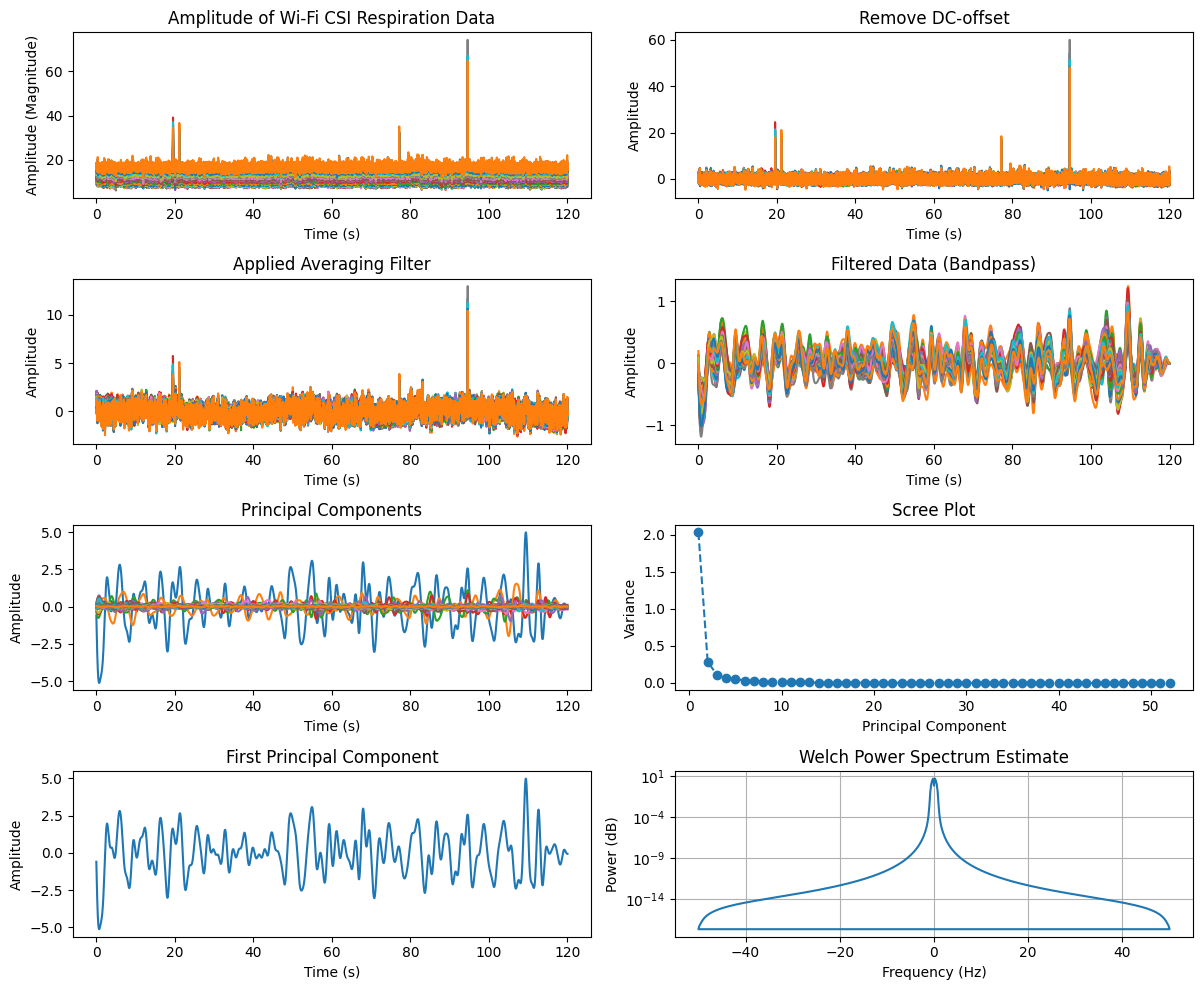

In [12]:
### Visualization (Optional)
# Create a time array for x-axis in seconds
time = np.arange(csi_data.shape[0]) / fs  # fs is the sampling frequency in Hz

# Plotting
plt.figure(figsize=(12, 10))


# Plot the amplitude over time
plt.subplot(4, 2, 1)
plt.plot(time, csi_data)
plt.title('Amplitude of Wi-Fi CSI Respiration Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Magnitude)')


# 2. Remove DC-offset
plt.subplot(4, 2, 2)
plt.plot(time, signal_dc_removed)
plt.title('Remove DC-offset')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 3. Applied Averaging Filter
plt.subplot(4, 2, 3)
plt.plot(time[:len(smoothed_signal)], smoothed_signal)
plt.title('Applied Averaging Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 4. Filtered Data (Bandpass)
plt.subplot(4, 2, 4)
plt.plot(time[:len(filtered_signal)], filtered_signal)  # Adjust time length for filtered signal
plt.title('Filtered Data (Bandpass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 5. Principal Components
plt.subplot(4, 2, 5)
plt.plot(time[:len(pca_components)], pca_components)  # Adjust time length for PCA components
plt.title('Principal Components')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 6. Scree Plot
plt.subplot(4, 2, 6)
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance')


# 7. First Principal Component
plt.subplot(4, 2, 7)
plt.plot(time[:len(first_pc)], first_pc)  # Adjust time length for first principal component
plt.title('First Principal Component')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 8. Welch Power Spectrum Estimate
plt.subplot(4, 2, 8)
plt.semilogy(freqs_symmetric, psd_symmetric)
plt.title('Welch Power Spectrum Estimate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.grid()
plt.tight_layout()
plt.show()

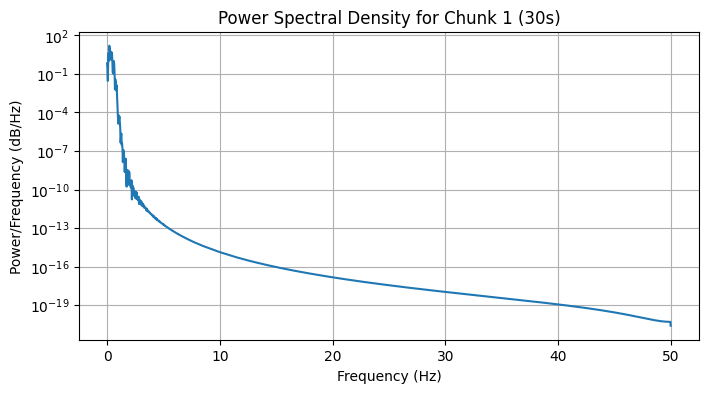

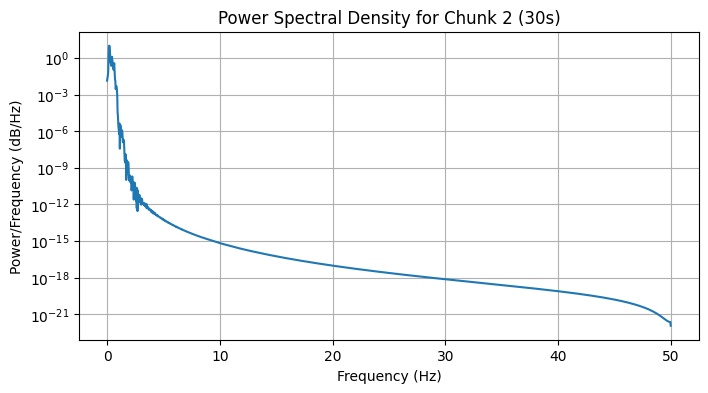

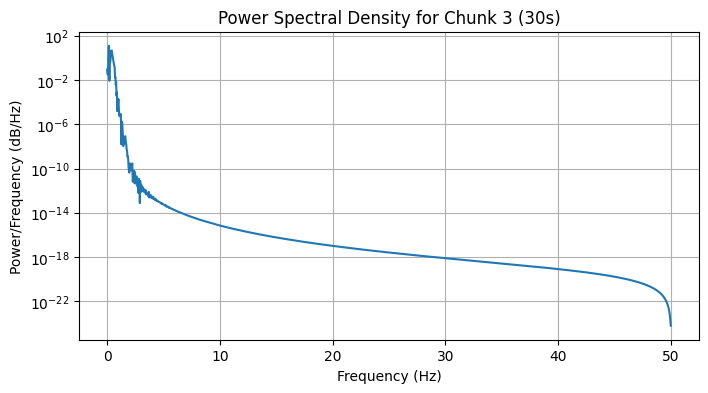

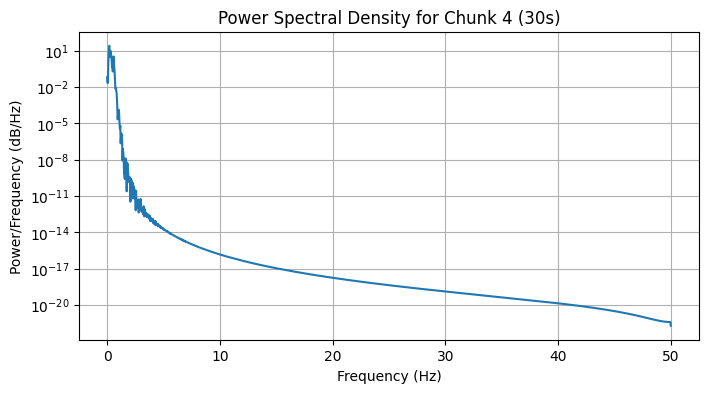

In [13]:
chunk_size = 30 * fs
num_chunks = len(first_pc)//chunk_size
num_chunks

for i in range(num_chunks):
  chunk = first_pc[i * chunk_size:(i + 1) * chunk_size]
  freqs, psd = welch(chunk, fs=fs, nperseg=chunk_size)

  # Step 4: Plot the PSD
  plt.figure(figsize=(8, 4))
  plt.semilogy(freqs, psd)
  plt.title(f'Power Spectral Density for Chunk {i+1} (30s)')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Power/Frequency (dB/Hz)')
  plt.grid(True)
  plt.show()